In [1]:
import data
import time

import torch
from torch import nn
import torchaudio
import torchaudio.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

path = './data/'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [2]:
class PreProcessor(torch.nn.Module):
    def __init__(
        self,
        input_samplerate = 16000,
        resample_samplerate = 16000,
        n_fft = 480,
        power=None
    ):
        super().__init__()
        self.output_size = (n_fft+2)//2
        self.resample = transforms.Resample(input_samplerate, resample_samplerate)
        self.transform = transforms.Spectrogram(n_fft=n_fft, power=power, center=True, window_fn=torch.hann_window)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        resampled = self.resample(waveform)
        spec = self.transform(resampled)
        spec = spec.permute(0, 2, 1)
        return spec


class PostProcessor(torch.nn.Module):
    def __init__(
        self,
        output_samplerate = 16000,
        resample_samplerate = 16000,
        n_fft = 480
    ):
        super().__init__()
        n_fft = n_fft
        self.resample = transforms.Resample(resample_samplerate, output_samplerate)
        self.transform = transforms.InverseSpectrogram(n_fft=n_fft, center=True, window_fn=torch.hann_window)

    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        spec = spec.permute(0, 2, 1)
        waveform = self.transform(spec)
        resampled = self.resample(waveform)
        return resampled

In [3]:
class MelLoss(torch.nn.Module):
    def __init__(
        self,
        sample_rate,
        n_stft=101,
        n_mels=10,
        device='cpu'
    ):
        super().__init__()
        self.melscale_transform = torchaudio.functional.melscale_fbanks(
            n_stft,
            f_min = 0,
            f_max = sample_rate / 2.0,
            n_mels = n_mels,
            sample_rate = sample_rate,
            norm = 'slaney',
        ).to(device)

    def __str__(self):
        return "MelLoss"
        
    def forward(self, estimated_spec, reference_spec):        
        mel_error_spec = torch.matmul(            
            (estimated_spec - reference_spec).abs()**2,
            self.melscale_transform
        )
        return mel_error_spec.clamp(min=1e-6).log().mean(dim=-2).mean()


class CombinedSpectralLoss(torch.nn.Module):
    def __init__(self, alpha = 0.5):
        super().__init__()
        self.mse_loss = nn.L1Loss()
        self.alpha = alpha
    
    def forward(self, est_spec, clean_spec):
        est_spec_real = est_spec.real
        est_spec_imag = est_spec.imag
        
        clean_spec_real = clean_spec.real
        clean_spec_imag = clean_spec.imag
        
        l_mag = self.mse_loss(est_spec.abs(), clean_spec.abs())
        print(l_mag)
        l_ri = self.mse_loss(est_spec_real, clean_spec_real) + self.mse_loss(est_spec_imag, clean_spec_imag) 
        print(l_ri)
        loss = self.alpha * l_mag + (1 - self.alpha) * l_ri
        return loss.clamp(min=1e-6).mean()

In [4]:
def train(
    dataloader, 
    dataset, 
    model, 
    preprocessor, 
    loss_fn, 
    optimizer, 
    scheduler=None, 
    epochs=1,
):
    size = len(dataset)
    model.train()
    start_time = time.perf_counter()

    for epoch in range(epochs):
        flag = False

        for batch, (noisy_batch, clean_batch, _) in enumerate(dataloader):
            noisy_spec = preprocessor(noisy_batch).to(device)
            clean_spec = preprocessor(clean_batch).to(device)

            batch_size = noisy_batch.shape[0]

            est_clean_spec = model(noisy_spec)
            loss = loss_fn(est_clean_spec, clean_spec)
            
            if scheduler:
                scheduler.step(loss)

            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Encountered NaN loss at batch {batch}, skipping this batch.")
                flag = True
                break

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            if (batch+1) % 10 == 0:
                torch.save(model, "./experiments/models/crn-model-checkpoints.pt")

            if (batch+1) % 10 == 0:
                curr_time = time.perf_counter()
                loss, current = loss.item(), 1 + (batch)*batch_size + epoch*size
                print(f"loss: {loss:>7f} [{current:>5d}/{size*epochs:>5d}] at {curr_time-start_time:>5f} sec")
                start_time = curr_time

        if flag:
            break

In [5]:
class CNNBlock(nn.Module):
    def __init__(
        self, 
        in_channels,
        out_channels, 
        kernel_size=(2, 5), 
        stride=(1, 2), 
        padding=(0, 2), 
        is_decoder=False, 
        is_last=False
    ):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding) if not is_decoder else\
                nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(num_features=out_channels),
            nn.PReLU() if not is_last else nn.Identity(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), stride=(1, 1)),
            nn.BatchNorm2d(num_features=out_channels),
            nn.PReLU() if not is_last else nn.Identity()
        )

    def forward(self, x):
        out = self.conv(x)
        return out


class CRN(nn.Module):
    def __init__(
        self,
        n_fft=101,
        gru_layers=1,
        device='cpu',
    ):
        super().__init__()
        self.eps = 1e-9
        self.device = device
        self.spec_size = n_fft // 2 + 1

        self.en_conv1 = CNNBlock(in_channels=1, out_channels=16)
        self.en_conv2 = CNNBlock(in_channels=16, out_channels=32)
        self.en_conv3 = CNNBlock(in_channels=32, out_channels=64)
        self.en_conv4 = CNNBlock(in_channels=64, out_channels=128)
        self.en_conv5 = CNNBlock(in_channels=128, out_channels=256)

        self.gru = nn.GRU(input_size=256 * 17, hidden_size=256 * 17, num_layers=gru_layers, bidirectional=False, batch_first=True)
        self.norm_and_act = nn.Sequential(
            nn.LayerNorm(256 * 17),
            nn.LeakyReLU(),
        )

        self.de_conv1 = CNNBlock(in_channels=256 + 256, out_channels=128, is_decoder=True)
        self.de_conv2 = CNNBlock(in_channels=128 + 128, out_channels=64, is_decoder=True)
        self.de_conv3 = CNNBlock(in_channels=64 + 64, out_channels=32, is_decoder=True)
        self.de_conv4 = CNNBlock(in_channels=32 + 32, out_channels=16, is_decoder=True)
        self.de_conv5 = CNNBlock(in_channels=16 + 16, out_channels=3, is_decoder=True, is_last=True)

        self.compress = nn.Linear(in_features=self.spec_size * 2 - 1, out_features=self.spec_size)

    def forward(self, input_spec: torch.Tensor):
        # Feature engineering
        x_real = input_spec.real
        x_imag = input_spec.imag

        x = torch.cat((x_real, x_imag), dim=-1)
        x = x.unsqueeze(1)

        # Encoding
        en_out1 = self.en_conv1(x)
        en_out2 = self.en_conv2(en_out1)
        en_out3 = self.en_conv3(en_out2)
        en_out4 = self.en_conv4(en_out3)
        en_out5 = self.en_conv5(en_out4)

        # LSTM
        out = en_out5.permute(0, 2, 1, 3)
        out = en_out5.contiguous().view(out.size(0), out.size(1), -1)
        gru_out, _ = self.gru(out)
        gru_out = self.norm_and_act(gru_out)
        gru_out = gru_out.permute(0, 2, 1).contiguous().view(*en_out5.shape)

        # Decoding
        de_out1 = self.de_conv1(torch.cat((gru_out, en_out5), dim=1))
        de_out2 = self.de_conv2(torch.cat((de_out1, en_out4), dim=1))
        de_out3 = self.de_conv3(torch.cat((de_out2, en_out3), dim=1))
        de_out4 = self.de_conv4(torch.cat((de_out3, en_out2), dim=1))
        de_out5 = self.de_conv5(torch.cat((de_out4, en_out1), dim=1))
        masks = self.compress(de_out5.permute(1, 0, 2, 3))

        # Complex spectrogram reconstruction
        x_magnitude = input_spec.abs()
        x_phase = input_spec.angle()

        mag_mask = torch.sigmoid(masks[0, :].squeeze(0))
        magnitude = mag_mask * x_magnitude

        real_phase_mask = torch.tanh(masks[1, :].squeeze(0))
        imag_phase_mask = torch.tanh(masks[2, :].squeeze(0))

        real_phase_mask = real_phase_mask / torch.sqrt(real_phase_mask ** 2 + imag_phase_mask ** 2 + self.eps)
        imag_phase_mask = imag_phase_mask / torch.sqrt(real_phase_mask ** 2 + imag_phase_mask ** 2 + self.eps)

        real_part = magnitude * (real_phase_mask * torch.cos(x_phase) - imag_phase_mask * torch.sin(x_phase))
        imag_part = magnitude * (real_phase_mask * torch.sin(x_phase) + imag_phase_mask * torch.cos(x_phase))

        out = torch.complex(real_part, imag_part)
        return out

In [6]:
batch_size = 16
n_epoch = 5
lr = 5e-4
n_fft = 512
n_mels = 50

dataset = data.NoisySpeech(path, device=device)
_, _, input_samplerate = dataset.__getitem__(0)
resample_samplerate = 16000

enhancer = CRN(n_fft=n_fft, gru_layers=3)
enhancer.to(device)

optimizer = torch.optim.RMSprop(params=enhancer.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, threshold=0.05, min_lr=1e-5)
loss = CombinedSpectralLoss(alpha=0.4)
# loss = MelLoss(sample_rate=16000, n_stft=n_fft // 2 + 1, n_mels=n_mels)
preprocessor = PreProcessor(input_samplerate=input_samplerate, n_fft=n_fft, power=None)

train_size = int(0.2 * len(dataset))
eval_size = int(0.2 * len(dataset))
leftover = len(dataset) - train_size - eval_size

train_dataset, eval_dataset, _ = torch.utils.data.random_split(dataset, [train_size, eval_size, leftover])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data.collate_fn)

train(
    dataloader=train_dataloader,
    dataset=train_dataset,
    model=enhancer,
    preprocessor=preprocessor,
    loss_fn=loss,
    optimizer=optimizer,
    epochs=n_epoch,
    scheduler=None,
)

tensor(4300.9106, grad_fn=<MeanBackward0>)
tensor(9897.8984, grad_fn=<AddBackward0>)
tensor(4349.2163, grad_fn=<MeanBackward0>)
tensor(8496.7568, grad_fn=<AddBackward0>)
tensor(3489.8423, grad_fn=<MeanBackward0>)
tensor(6410.7354, grad_fn=<AddBackward0>)
tensor(3647.0215, grad_fn=<MeanBackward0>)
tensor(8162.2480, grad_fn=<AddBackward0>)
tensor(4085.9338, grad_fn=<MeanBackward0>)
tensor(7305.7705, grad_fn=<AddBackward0>)
tensor(2649.2908, grad_fn=<MeanBackward0>)
tensor(5421.9067, grad_fn=<AddBackward0>)
tensor(2371.5076, grad_fn=<MeanBackward0>)
tensor(6062.7969, grad_fn=<AddBackward0>)
tensor(2119.4219, grad_fn=<MeanBackward0>)
tensor(5111.0234, grad_fn=<AddBackward0>)
tensor(2136.6909, grad_fn=<MeanBackward0>)
tensor(5855.5205, grad_fn=<AddBackward0>)
tensor(2218.2388, grad_fn=<MeanBackward0>)
tensor(5036.7812, grad_fn=<AddBackward0>)
loss: 3909.364258 [  145/11570] at 432.558790 sec
tensor(2545.7246, grad_fn=<MeanBackward0>)
tensor(5825.3091, grad_fn=<AddBackward0>)
tensor(2409.702

In [7]:
torch.save(enhancer, "./experiments/models/crn-model-normal-loss.pt")

In [35]:
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=batch_size, shuffle=True, collate_fn=data.collate_fn)
noisy_batch, clean_batch, sr = next(iter(eval_loader))
noisy_spec = preprocessor(noisy_batch).to(device)
clean_spec = preprocessor(clean_batch).to(device)

postprocessor = PostProcessor(output_samplerate=input_samplerate, n_fft=n_fft)

enhancer.eval()
with torch.no_grad():
    enhanced_spec = enhancer(noisy_spec)


enhanced_batch = postprocessor(enhanced_spec.to('cpu'))
clean_audio = postprocessor(clean_spec.to('cpu'))
noisy_audio = postprocessor(noisy_spec.to('cpu'))

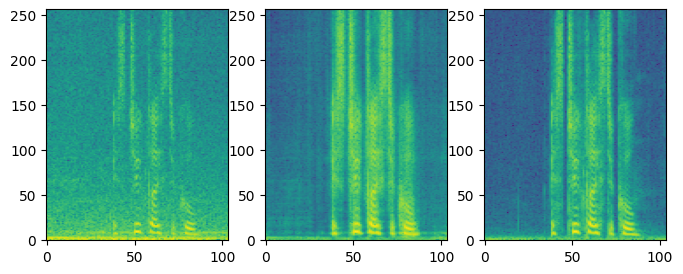

In [38]:
idx = np.random.randint(16)
plt.figure(figsize=(8,3))
plt.subplot(131)
plt.imshow(noisy_spec[idx,:,:].to('cpu').abs().log().mT.numpy(),origin='lower', aspect="auto")
plt.subplot(132)
plt.imshow(enhanced_spec[idx,:,:].to('cpu').abs().log().mT.detach().numpy(),origin='lower', aspect="auto")
plt.subplot(133)
plt.imshow(clean_spec[idx,:,:].to('cpu').abs().log().mT.numpy(),origin='lower', aspect="auto")
plt.show()

import IPython
IPython.display.display(IPython.display.Audio(noisy_batch[idx,:].detach().numpy(),rate=int(sr)))
IPython.display.display(IPython.display.Audio(enhanced_batch[idx,:].detach().numpy(),rate=int(sr)))
IPython.display.display(IPython.display.Audio(clean_batch[idx,:],rate=int(sr)))